# Skin Lesion Segmentation

In [1]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import os, sys, json, tqdm
import PIL
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch import nn, optim
from sklearn.model_selection import KFold
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt

import random
random.seed(233)

## 1. Build the dataset

In [2]:
image_list = [i for i in os.listdir("./skin_lesion_dataset") if i.startswith("IMD")]
random.shuffle(image_list)

n = len(image_list)
train_list = image_list[:int(0.8 * n)]
test_list = image_list[int(0.8 * n):]

In [3]:
class LesionDataset(Dataset):
    def __init__(self, root_path, data_list, mode):
        self.root_path = root_path
        self.data_list = data_list
        self.mode = mode

        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.aug = transforms.Compose([
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(256),
        ])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_name = self.data_list[idx]

        image = PIL.Image.open(
            os.path.join(self.root_path, image_name, f"{image_name}_Dermoscopic_Image", f"{image_name}.bmp"))
        image = self.norm(image)

        mask = PIL.Image.open(
            os.path.join(self.root_path, image_name, f"{image_name}_lesion", f"{image_name}_lesion.bmp"))
        mask = torch.tensor(np.array(mask)).float()
        mask[mask == 0] = 0
        mask[mask > 0] = 1

        if self.mode == 'train':
            data = torch.cat([image, mask.unsqueeze(0)], dim=0)
            data = self.aug(data)
            image = data[:3, :, :]
            mask = data[3:, :, :]

        return image, mask

In [4]:
train_dataset = LesionDataset("./skin_lesion_dataset", train_list, 'train')
valid_dataset = LesionDataset("./skin_lesion_dataset", test_list, "valid")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1)

## 2. Build the segmentation model

In [5]:
# Use pretrained Deeplab-v3 and only train its classifier head
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[-1] = torch.nn.Sequential(
    nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 3. Train and evalute models

In [6]:
# hyper-parameters
batch_size = 10
num_epochs = 10
record_gap = 20
lr = 1e-4

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)

# train and valid the model
model.train()
sum_train_loss = sum_step = 0
for epoch in range(num_epochs):
    # train
    for inputs, labels in train_loader:
        sum_step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)['out']
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # record the training loss
        sum_train_loss += loss.item()
        
    avg_train_loss = sum_train_loss / sum_step
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}")
    
    # valid
    model.eval()
    sum_valid_correct = sum_valid_pixel = sum_valid_loss = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['out']
            # record the pixel accuracy
            predicted = torch.zeros_like(outputs)
            predicted[outputs > 0.5] = 1.0
            predicted = predicted[0, :, :, :]
            sum_valid_correct += (predicted == labels).sum().item()
            sum_valid_pixel += outputs.shape[-1] * outputs.shape[-2]
            # record the loss
            labels = labels.unsqueeze(0)
            sum_valid_loss += criterion(outputs, labels).item()

    sum_valid_loss = sum_valid_loss / len(valid_loader)
    sum_valid_correct = sum_valid_correct / sum_valid_pixel * 100
    print(f'Epoch: {epoch}, Validation Loss: {sum_valid_loss:.4f}, Accuracy: {sum_valid_correct:.2f}%')

Epoch: 0, Training Loss: 0.6902152021725972


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0, Validation Loss: 0.6714, Accuracy: 61.58%
Epoch: 1, Training Loss: 0.6845012356837591
Epoch: 1, Validation Loss: 0.6264, Accuracy: 74.25%
Epoch: 2, Training Loss: 0.6708841264247895
Epoch: 2, Validation Loss: 0.5837, Accuracy: 80.38%
Epoch: 3, Training Loss: 0.6542521109183629
Epoch: 3, Validation Loss: 0.5392, Accuracy: 83.70%
Epoch: 4, Training Loss: 0.637222964366277
Epoch: 4, Validation Loss: 0.4932, Accuracy: 86.16%
Epoch: 5, Training Loss: 0.6173106165395843
Epoch: 5, Validation Loss: 0.4426, Accuracy: 89.30%
Epoch: 6, Training Loss: 0.598311468675023
Epoch: 6, Validation Loss: 0.3936, Accuracy: 90.48%
Epoch: 7, Training Loss: 0.5757596708834172
Epoch: 7, Validation Loss: 0.3306, Accuracy: 92.18%
Epoch: 8, Training Loss: 0.5550816112094455
Epoch: 8, Validation Loss: 0.2826, Accuracy: 93.22%
Epoch: 9, Training Loss: 0.5354193472862243
Epoch: 9, Validation Loss: 0.2404, Accuracy: 93.95%


In [7]:
    # save the model
    import datetime

    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    torch.save(model, f"model_{current_time}.pth")

## 4. Build the test dataset

In [8]:
class NewDataLesionDataset(Dataset):
    def __init__(self, root_path, data_list):
        self.root_path = root_path
        self.data_list = data_list

        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        folder_name = f"Test{self.data_list[idx]:02d}"
        image_path = os.path.join(self.root_path, folder_name, f"{folder_name.lower()}.bmp")

        image = PIL.Image.open(image_path)
        image = self.norm(image)

        return image, folder_name

In [9]:
new_data_list = list(range(1, 51))

new_data_dataset = NewDataLesionDataset("./test_dataset", new_data_list)
new_data_loader = DataLoader(new_data_dataset, batch_size=1)

## 5. Visualization  on test dataset

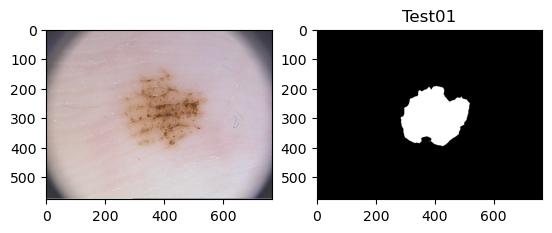

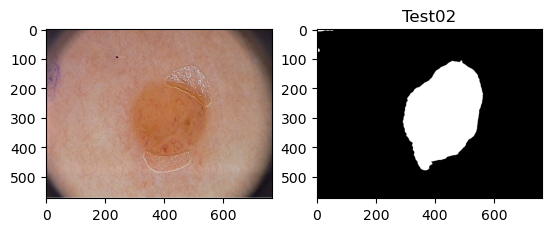

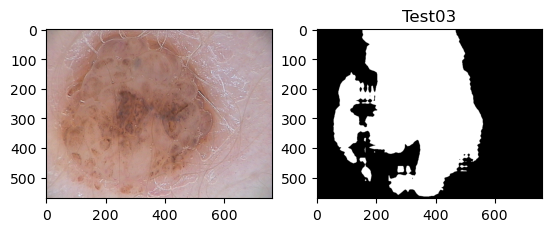

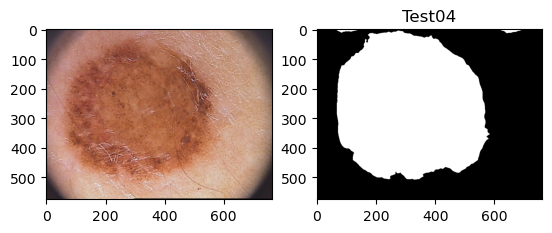

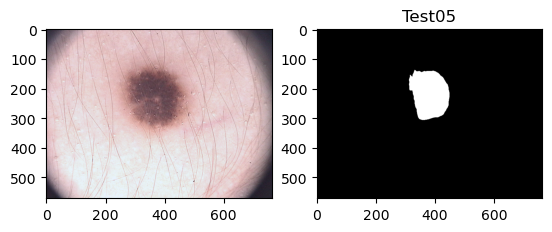

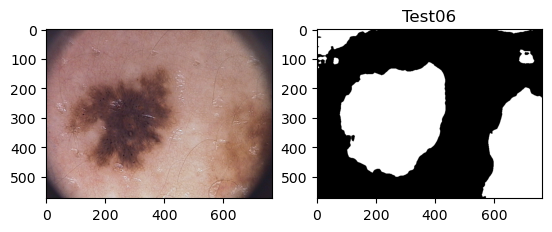

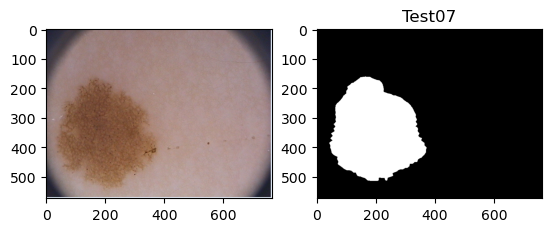

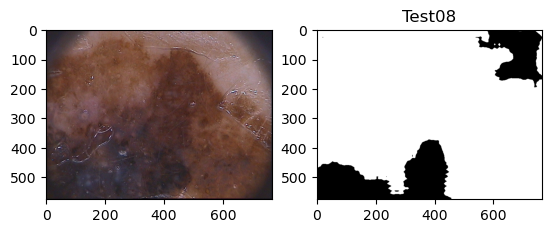

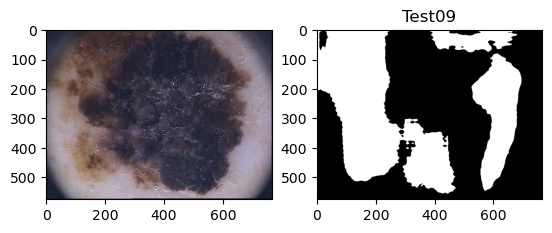

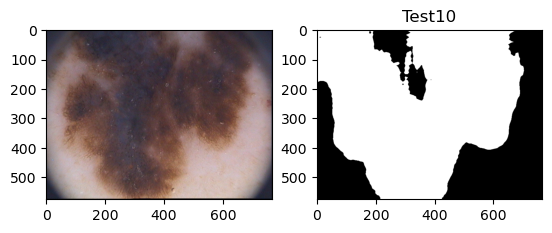

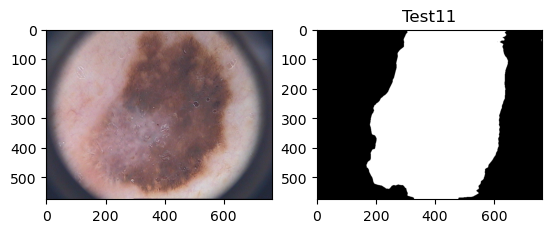

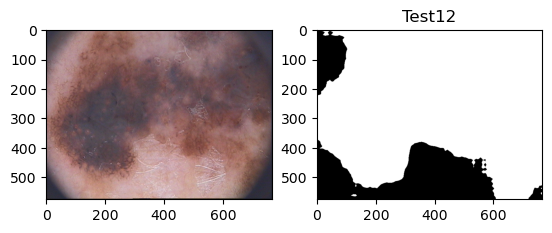

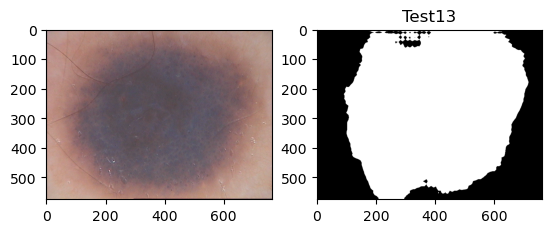

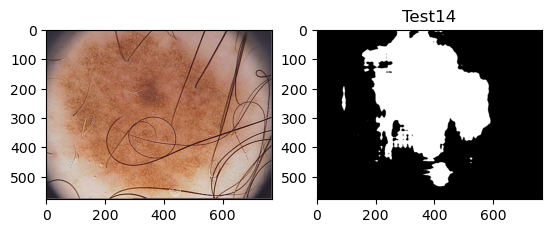

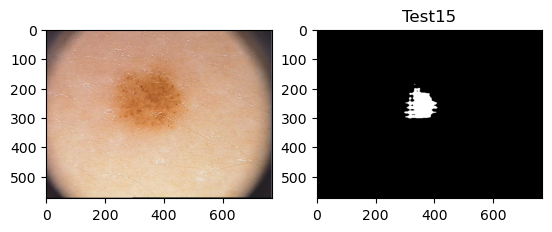

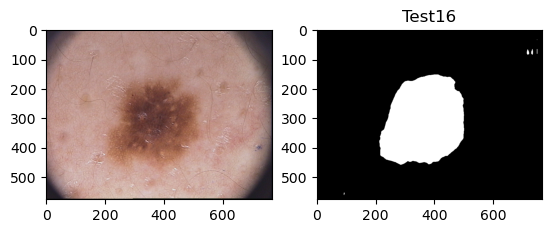

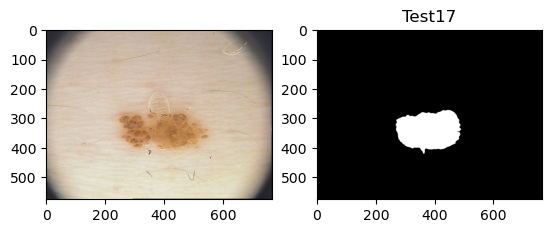

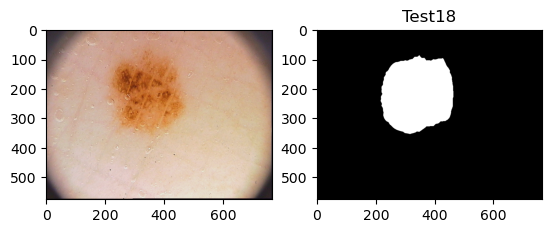

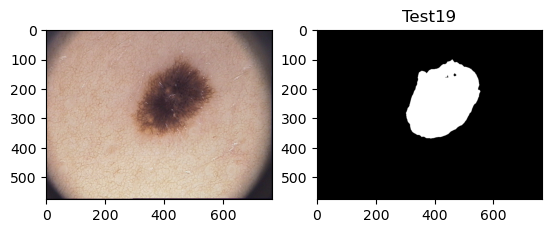

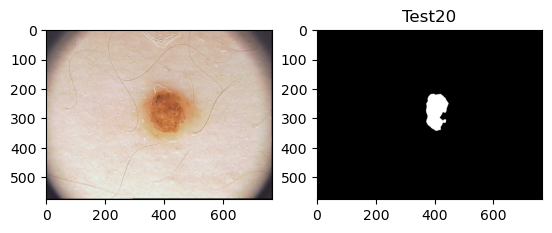

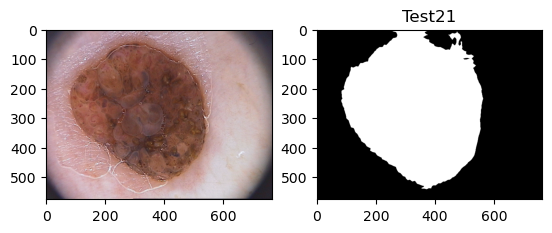

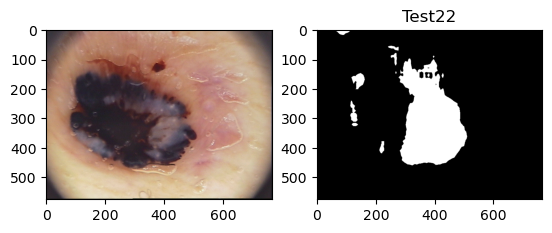

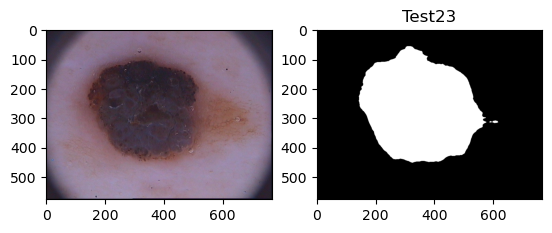

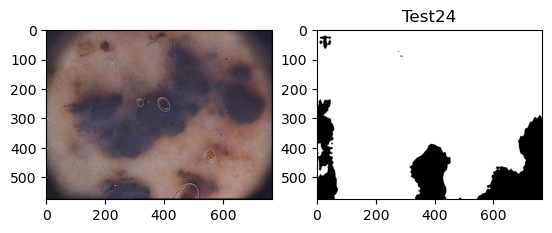

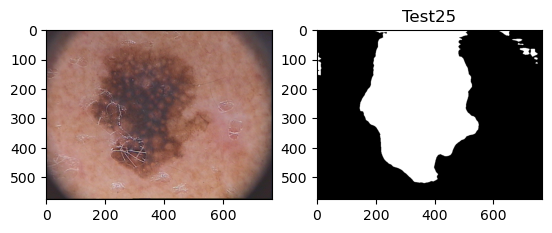

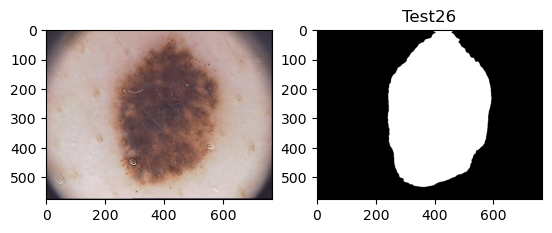

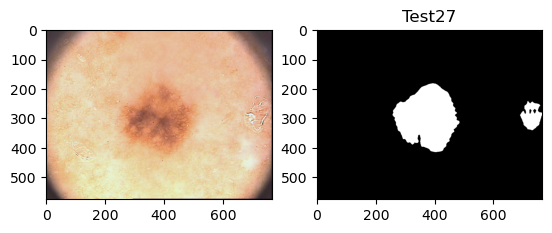

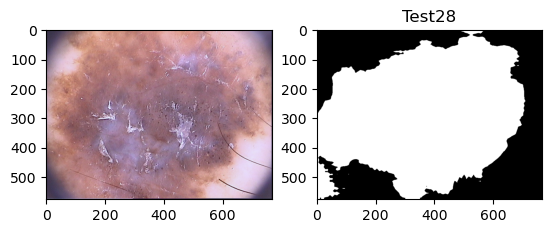

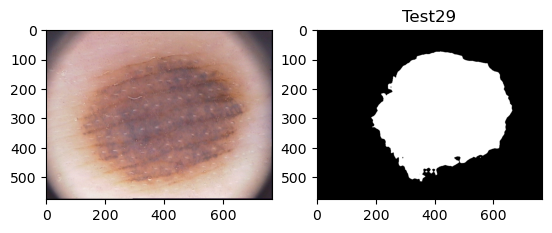

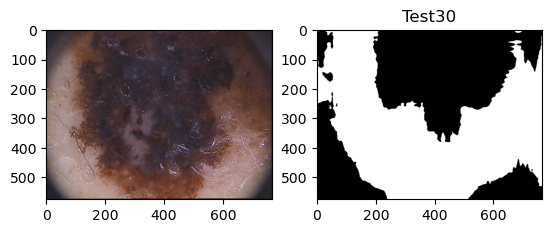

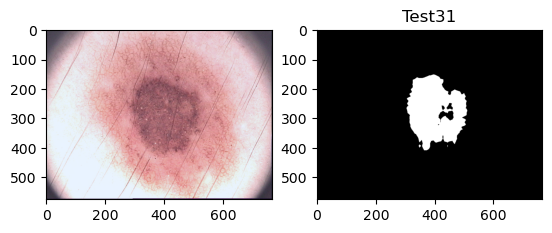

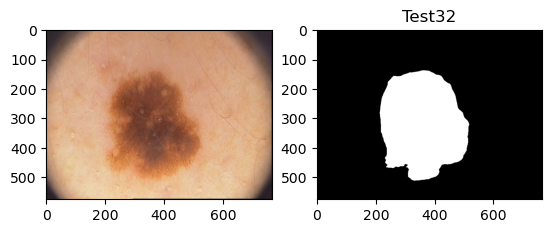

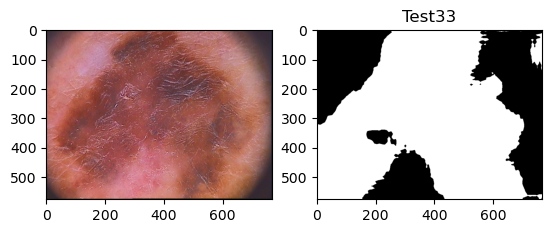

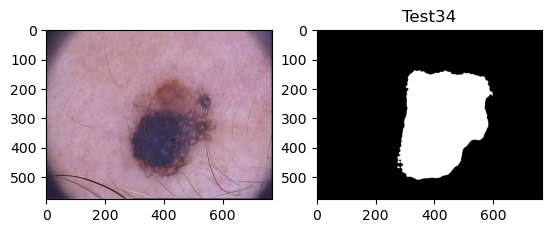

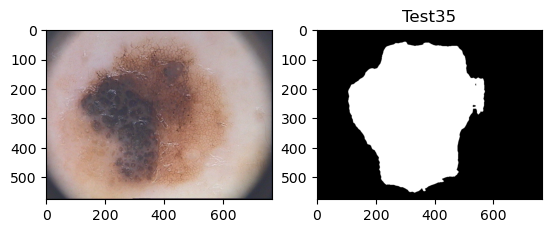

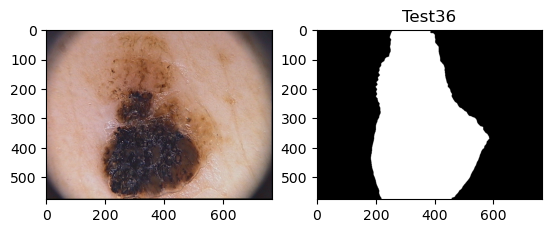

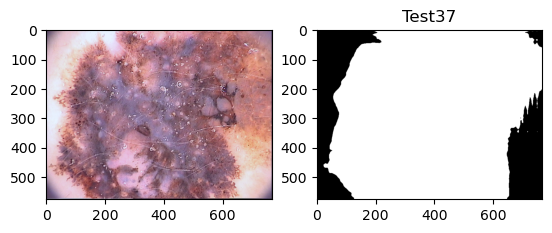

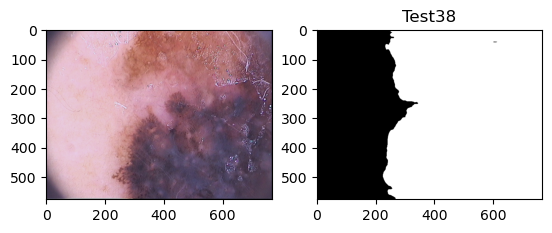

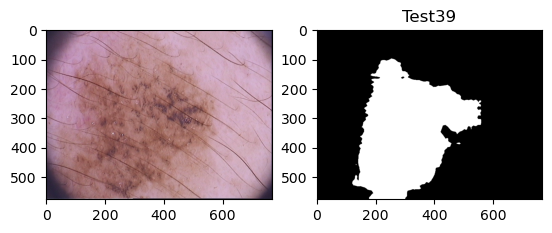

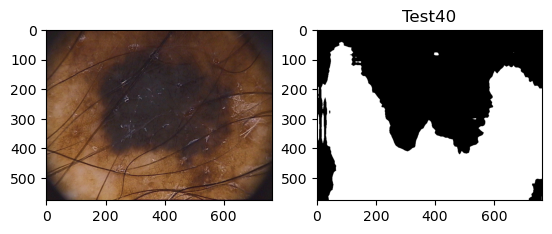

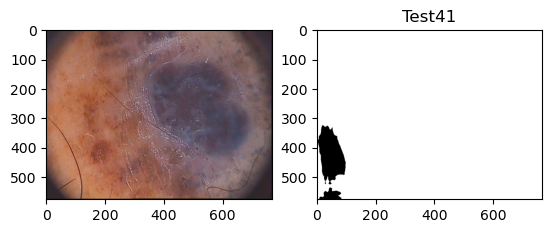

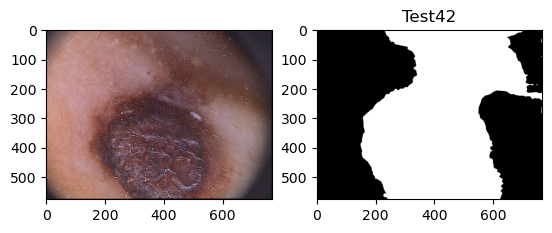

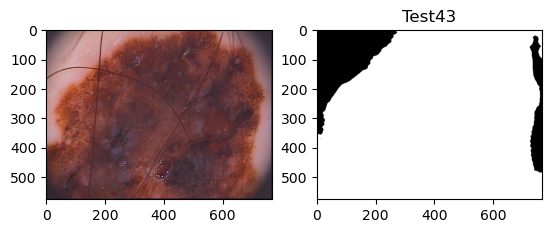

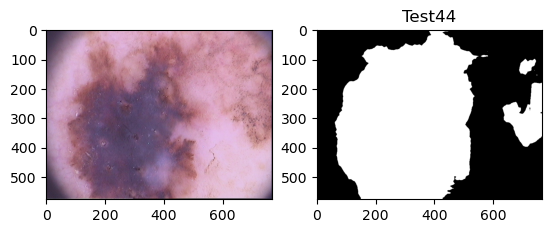

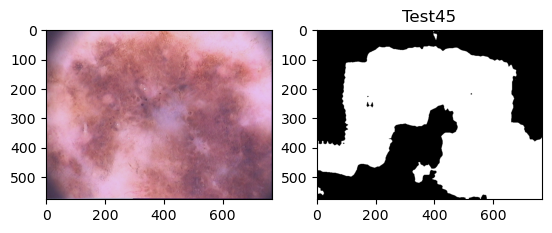

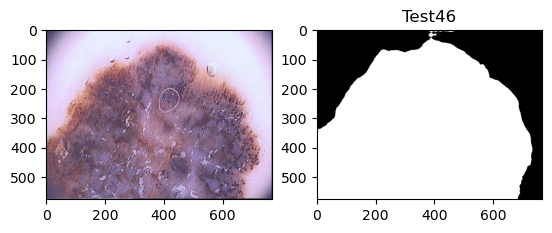

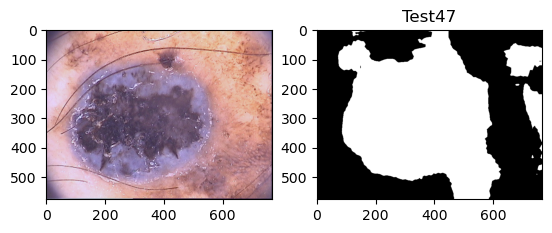

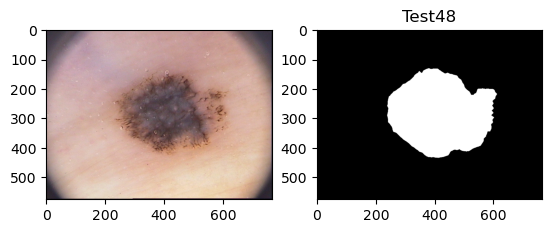

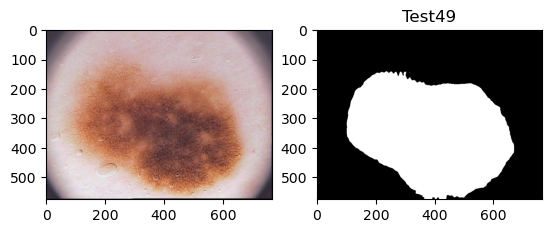

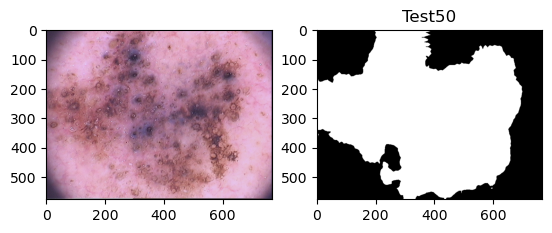

In [10]:
threshold = 0.5

for inputs, folder_names in new_data_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)['out']

    predicted = torch.zeros_like(outputs)
    predicted[outputs > threshold] = 1.0
    predicted = predicted[0, :, :, :]

    plt.figure()
    plt.subplot(1, 2, 1)
    image = inputs[0, :, :, :].transpose(0, 2).transpose(0, 1).cpu().numpy()
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    predicted = predicted[0, :, :].cpu().numpy()
    plt.imshow(predicted, cmap='gray')
    plt.title(folder_names[0])
    plt.show()